In [2]:
# loading libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
import joblib

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load all 3 files
def load_data(file_path, source):
    df = pd.read_csv(file_path, sep='\t', header=None, names=['sentence', 'label'])
    df['source'] = source
    return df

amazon_df = load_data('../data/amazon_cells_labelled.txt', 'amazon')
yelp_df = load_data('../data/yelp_labelled.txt', 'yelp')
imdb_df = load_data('../data/imdb_labelled.txt', 'imdb')

# Combine into one DataFrame
df = pd.concat([amazon_df, yelp_df, imdb_df]).reset_index(drop=True)

In [4]:
# View a sample of the data
print("Data shape:", df.shape, "\n")
df.sample(5)

Data shape: (2748, 3) 



,sentence,label,source
416,An Awesome New Look For Fall 2000!.,1,amazon
1073,"It took over 30 min to get their milkshake, wh...",0,yelp
2202,A good commentary of today's love and undoubte...,1,imdb
2658,I highly doubt that anyone could ever like thi...,0,imdb
2279,The directing is sloppy at best.,0,imdb


In [5]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())

Missing values:
 sentence    0
label       0
source      0
dtype: int64
Duplicate rows: 17


**1. Basic EDA**

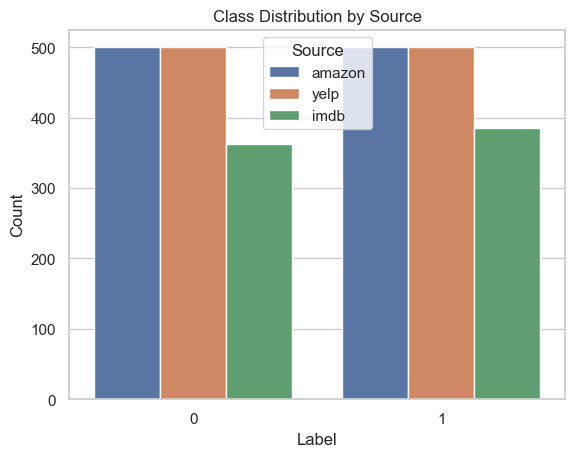

In [6]:
# Class distribution of labels across sources
sns.countplot(x='label', hue='source', data=df)
plt.title('Class Distribution by Source')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(title='Source')
plt.show()

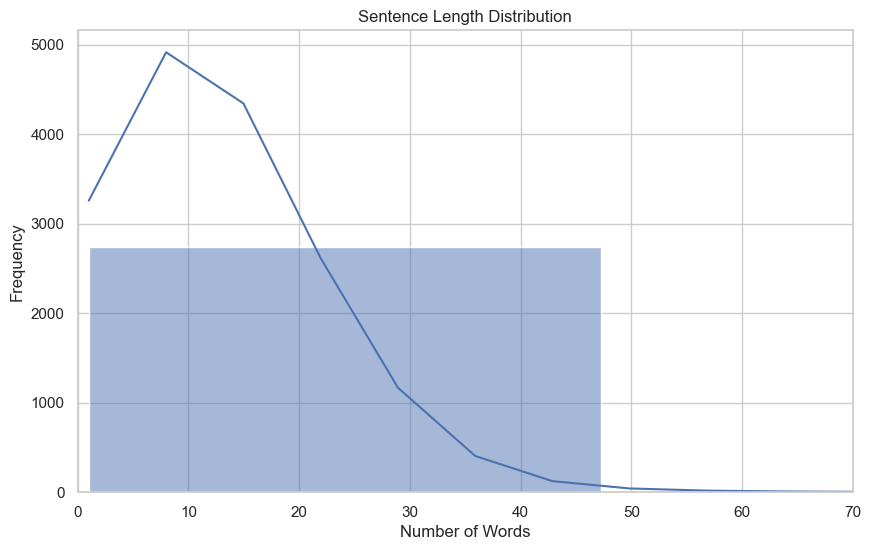

In [7]:
# Sentence length distribution
df['sentence_length'] = df['sentence'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['sentence_length'], bins=30, kde=True)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 70)
plt.show()

**2. Text Preprocessing**

I will clean the text to remove noise and prepare it for vectorization:

In [8]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning
df['cleaned_text'] = df['sentence'].apply(clean_text)

In [9]:
# Inspect cleaned text
df[['sentence', 'cleaned_text']].sample(5)

,sentence,cleaned_text
1480,We asked for the bill to leave without eating ...,asked bill leave without eating didnt bring ei...
2115,Artless camera-work endlessly presents us with...,artless camerawork endlessly presents us uglie...
1975,What happened next was pretty....off putting.,happened next prettyoff putting
2658,I highly doubt that anyone could ever like thi...,highly doubt anyone could ever like trash
742,It dit not work most of the time with my Nokia...,dit work time nokia


In [10]:
df.sample()

,sentence,label,source,sentence_length,cleaned_text
1127,"Phenomenal food, service and ambiance.",1,yelp,5,phenomenal food service ambiance


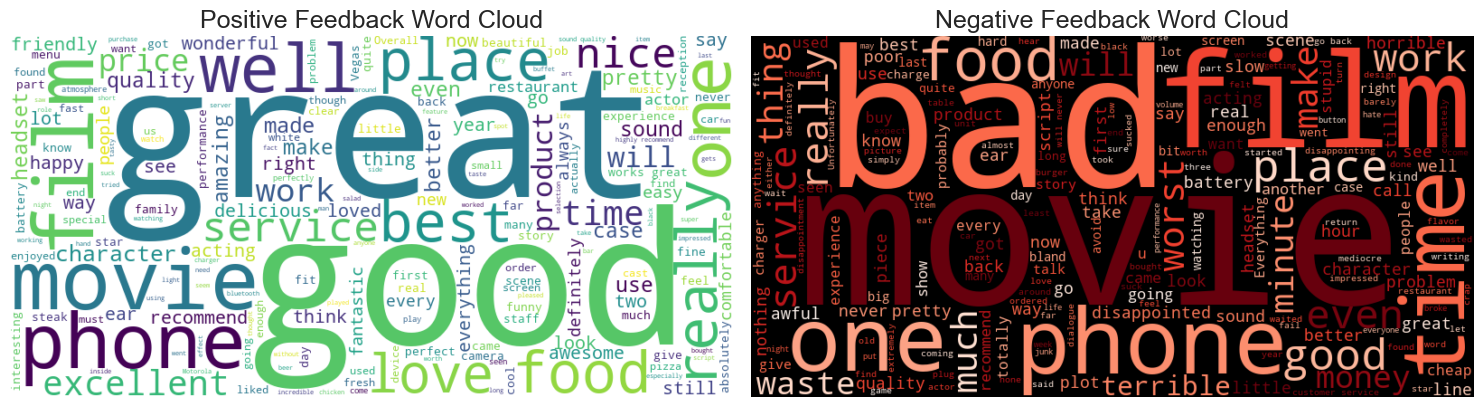

In [11]:
# Assuming your cleaned DataFrame is called `df`
positive_text = " ".join(df[df['label'] == 1]['sentence'])
negative_text = " ".join(df[df['label'] == 0]['sentence'])

# Generate word clouds
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Plot side by side
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Feedback Word Cloud", fontsize=18)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Feedback Word Cloud", fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()

In [22]:
import os
os.makedirs("docs", exist_ok=True)

# Save Word Clouds to 'docs/' folder
wordcloud_pos.to_file("../docs/positive_wc.png")
wordcloud_neg.to_file("../docs/negative_wc.png")

**3. TF-IDF Vectorization**

I'll convert the cleaned text into numerical features with `TfidfVectorizer`

In [12]:
# Create the vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # You can tweak max_features and ngrams

# Fit and transform the cleaned text
X = vectorizer.fit_transform(df['cleaned_text'])

# Target variable
y = df['label']

**4. Train/Test Split and Model Training**

I'll start with a few classic classifiers

In [13]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Model dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

# Collect metrics
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    results.append(evaluate_model(model, X_test, y_test, name))

# Create DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
results_df.reset_index(drop=True, inplace=True)

print(results_df)

                     Model  Accuracy  Precision    Recall  F1 Score
0  Multinomial Naive Bayes  0.829091   0.799296  0.859848  0.828467
1      Logistic Regression  0.836364   0.837209  0.818182  0.827586
2            Random Forest  0.809091   0.832636  0.753788  0.791252


**Model Comparison Breakdown**

| Model                     | Accuracy | Precision | Recall | F1 Score | Strengths                              | Weaknesses                            | Notes                                |
|--------------------------|----------|-----------|--------|----------|----------------------------------------|----------------------------------------|--------------------------------------|
| **Multinomial Naive Bayes** | 0.829    | 0.799     | **0.860** | **0.828** | High recall, good at catching positives | Slightly lower precision              | Simple, great baseline for text tasks |
| **Logistic Regression**  | **0.836** | **0.837** | 0.818  | 0.828    | Balanced, interpretable, stable         | Slightly lower recall than NB         | Great general-purpose model           |
| **Random Forest**        | 0.809    | 0.833     | 0.754  | 0.791    | Decent precision, captures patterns     | Lowest recall, risk of overfitting    | May not generalize well on small data |

- _Top F1 Score_: Naive Bayes (0.828), but Logistic Regression is right behind (0.827)

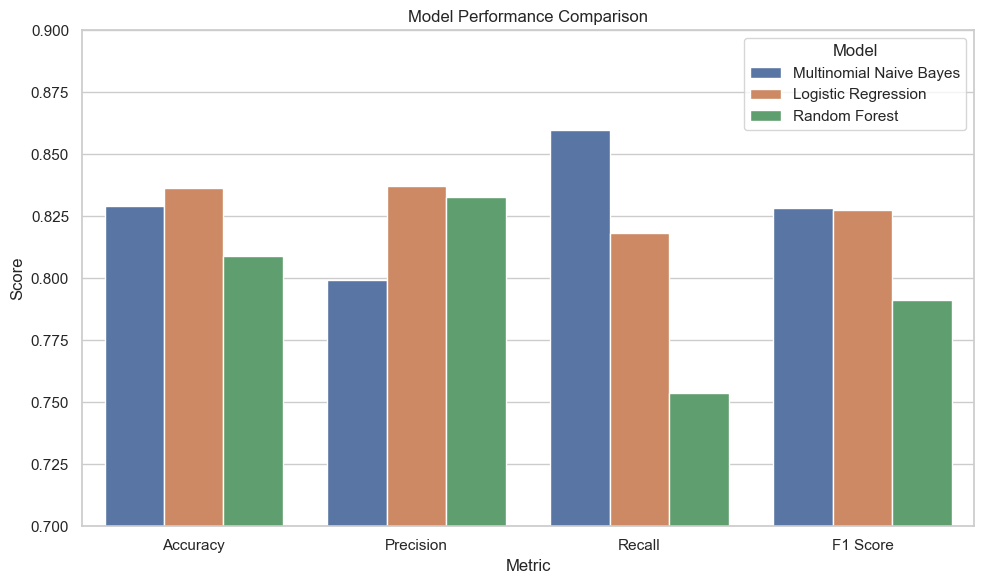

In [15]:
plt.figure(figsize=(10, 6))

# Melt the results DataFrame for easier plotting
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create barplot
sns.barplot(x='Metric', y='Score', hue='Model', data=results_melted)
plt.title('Model Performance Comparison')
plt.ylim(0.7, 0.9)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

Although Naive Bayes had a slightly higher F1 Score, Logistic Regression was chosen for deployment due to its more balanced performance across precision and recall.

In [16]:
# Select the best model of choice
best_model = models["Logistic Regression"]

# Save the selected model and vectorizer
joblib.dump(best_model, '../models/logistic_model.pkl')
joblib.dump(vectorizer, '../models/tfidf_vectorizer.pkl')

print("Saved Logistic Regression model and vectorizer.")

Saved Logistic Regression model and vectorizer.


### Sample Prediction

In [17]:
# Sample predictions using the Logistic Regression model
sample_sentences = [
    "I love how easy it was to use this product!",
    "Absolutely terrible experience, never buying again.",
    "It’s okay, not the best but not the worst.",
    "Customer service was quick and helpful.",
    "The quality was poor and it broke after one use."
]

# Transform input using existing pipeline
sample_features = vectorizer.transform(sample_sentences)  # Use same vectorizer as during training

# Predict sentiment
predictions = best_model.predict(sample_features)
probabilities = best_model.predict_proba(sample_features)

# Display results
for i, sentence in enumerate(sample_sentences):
    label = "Positive" if predictions[i] == 1 else "Negative"
    prob = probabilities[i][predictions[i]]
    print(f"Sentence: \"{sentence}\"")
    print(f"Predicted Sentiment: {label} ({prob:.2f} confidence)")
    print("-" * 60)


Sentence: "I love how easy it was to use this product!"
Predicted Sentiment: Positive (0.82 confidence)
------------------------------------------------------------
Sentence: "Absolutely terrible experience, never buying again."
Predicted Sentiment: Negative (0.80 confidence)
------------------------------------------------------------
Sentence: "It’s okay, not the best but not the worst."
Predicted Sentiment: Negative (0.56 confidence)
------------------------------------------------------------
Sentence: "Customer service was quick and helpful."
Predicted Sentiment: Positive (0.51 confidence)
------------------------------------------------------------
Sentence: "The quality was poor and it broke after one use."
Predicted Sentiment: Negative (0.79 confidence)
------------------------------------------------------------


## 🧾 Project Summary

### Problem Statement
This project focuses on classifying customer feedback into positive or negative sentiment. The goal is to build a model that can automatically detect sentiment from short customer reviews, which can be used in various applications such as review monitoring, customer satisfaction analysis, and product/service improvement.

---

### Solution Overview
- The dataset used is the [UCI Sentiment Labelled Sentences Data](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences), which contains 2,748 labeled sentences from sources like Yelp, Amazon, and IMDB.
- Preprocessing included cleaning text, converting to lowercase, removing stop words and punctuation.
- Multiple machine learning models were trained and evaluated:
  - **Logistic Regression**
  - **Multinomial Naive Bayes**
  - **Random Forest Classifier**
- Evaluation was based on **Accuracy**, **Precision**, **Recall**, and **F1 Score**.

---

### Model Selection Rationale
While **Multinomial Naive Bayes** had a slightly higher F1 Score, **Logistic Regression** was selected due to its **more balanced performance** across all evaluation metrics. This makes it a more reliable choice in real-world scenarios where both false positives and false negatives are critical.

---

### Insights
- Word cloud visualizations revealed common terms in positive and negative feedback.
- Logistic Regression demonstrated robust performance even with a relatively small dataset and simple preprocessing.
- A **Streamlit app** was developed to deploy the model and allow users to input sentences and get real-time sentiment predictions.

---

### Next Steps
- Try more advanced NLP models like **DistilBERT** for comparison.
- Fine-tune preprocessing with lemmatization or bigrams.
- Expand the dataset for improved generalization.
- Add confidence scores and interpretability features to the app.



In [ ]:
# import pkg_resources

# used_packages = ['pandas', 'scikit-learn', 'numpy', 'matplotlib', 'seaborn', 'wordcloud', 'streamlit']

# for pkg in used_packages:
#     version = pkg_resources.get_distribution(pkg).version
#     print(f"{pkg}=={version}")
# # Save the versions to a file
# with open('../requirements.txt', 'w') as f:
#     for pkg in used_packages:
#         version = pkg_resources.get_distribution(pkg).version
#         f.write(f"{pkg}=={version}\n")

pandas==1.5.3
scikit-learn==1.3.2
numpy==1.21.2
matplotlib==3.7.5
seaborn==0.13.2
wordcloud==1.9.4
streamlit==1.40.1
